In [50]:
import altair as alt
from vega_datasets import data
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [51]:
import pandas as pd
import numpy as np

In [284]:
data = pd.read_csv('data/cpj_dates_codes_alpha.csv')
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Type,Date,Name,Sex,Country_killed,Organization,Nationality,...,Local_Foreign,Source_fire,Type_death,Impunity_for_murder,Taken_captive,Threatened,Tortured,clean_dates,Country_code,Alpha_3_codes
0,0,0,0,Motive Confirmed,"October 22, 2016",Ali Risan,Male,Iraq,Al-Sumaria TV,Iraqi,...,Local,Political Group,Crossfire/Combat-Related,NaN,NaN,NaN,\r\r\r\n,2016-10-22,368.0,IRQ
1,1,1,1,Motive Confirmed,"October 21, 2016",Ahmet Haceroğlu,Male,Iraq,Türkmeneli TV,Iraqi,...,Local,Political Group,Crossfire/Combat-Related,NaN,NaN,NaN,\r\r\r\n,2016-10-21,368.0,IRQ
2,2,2,2,Motive Confirmed,"October 2, 2016",Jeroen Oerlemans,Male,Libya,Freelance,Netherlands,...,Foreign,Political Group,Crossfire/Combat-Related,NaN,NaN,NaN,\r\r\r\n,2016-10-02,434.0,LBY
3,3,3,3,Motive Confirmed,"August 14, 2016",Mustafa Said,Male,Iraq,Kurdistan TV,Iraqi,...,Local,Unknown Fire,Crossfire/Combat-Related,NaN,No,No,No\r\r\r\n,2016-08-14,368.0,IRQ
4,4,4,4,Motive Confirmed,"August 8, 2016",Shehzad Ahmed,NaN,Pakistan,Aaj News,Pakistani,...,Local,Political Group,Dangerous Assignment,NaN,No,No,No\r\r\r\n,2016-08-08,586.0,PAK


In [285]:
data.clean_dates = pd.to_datetime(data.clean_dates)
data['year'] = data.clean_dates.dt.to_period("Y")

In [286]:
from bs4 import BeautifulSoup
import requests

In [333]:
import requests
res = requests.get("https://en.wikipedia.org/wiki/ISO_3166-1_numeric#Officially_assigned_code_elements")
soup = BeautifulSoup(res.content,'xml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]

df = df.drop(0)

df.iloc[0][0] = "004"
df.columns = ["Country_code", "Country_killed"]
df['Country_code'] = df['Country_code'].astype(float)

In [372]:
counts = data.groupby([data.year, data.Country_killed, data.Country_code, data.Alpha_3_codes]).size().reset_index(name='counts')
#counts = data.groupby([data.Country_killed, data.Country_code]).size().reset_index(name='counts')

In [373]:
counts.head()

,year,Country_killed,Country_code,Alpha_3_codes,counts
0,1992,Algeria,12.0,DZA,1
1,1992,Angola,24.0,AGO,1
2,1992,Azerbaijan,31.0,AZE,1
3,1992,Bosnia,70.0,BIH,8
4,1992,Chad,148.0,TCD,3


In [374]:
counts['year'] = counts['year'].astype(str)

In [375]:
counts['year'] = pd.to_numeric(counts['year'])

In [376]:
counts_all = pd.merge(df, counts, on = 'Country_code', how='left')

In [377]:
counts_all.head()

,Country_code,Country_killed_x,year,Country_killed_y,Alpha_3_codes,counts
0,4.0,Afghanistan,1994.0,Afghanistan,AFG,1.0
1,4.0,Afghanistan,1998.0,Afghanistan,AFG,1.0
2,4.0,Afghanistan,2001.0,Afghanistan,AFG,9.0
3,4.0,Afghanistan,2006.0,Afghanistan,AFG,3.0
4,4.0,Afghanistan,2007.0,Afghanistan,AFG,3.0


In [378]:
counts_all.drop('Country_killed_y',inplace=True, axis=1)

In [379]:
counts_all = counts_all.fillna(0)

In [380]:
counts_all.head()

,Country_code,Country_killed_x,year,Alpha_3_codes,counts
0,4.0,Afghanistan,1994.0,AFG,1.0
1,4.0,Afghanistan,1998.0,AFG,1.0
2,4.0,Afghanistan,2001.0,AFG,9.0
3,4.0,Afghanistan,2006.0,AFG,3.0
4,4.0,Afghanistan,2007.0,AFG,3.0


In [381]:
counts_all['Country_code'] = pd.to_numeric(counts_all['Country_code'])
#counts_all['Country_code'] = counts_all['Country_code'].astype(int)

In [382]:
from vega_datasets import data as data_vega
countries = alt.topo_feature(data_vega.world_110m.url, 'countries')

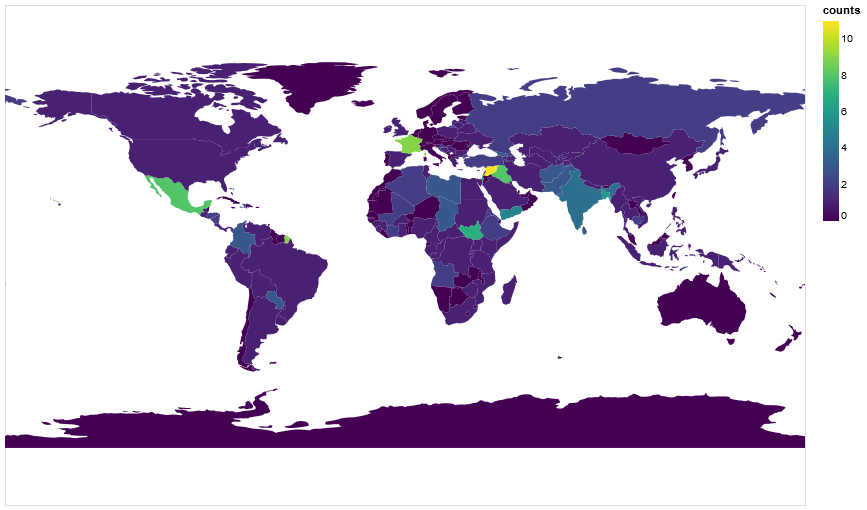

In [383]:
alt.Chart(countries).mark_geoshape().project(
    type='equirectangular'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(counts_all, 'Country_code', ['Country_code','year','Country_killed_x','counts'])
).encode(
    color='counts:Q',
    tooltip=['Country_killed_x:N','counts:Q', 'year:Q']
).properties(
    width=800,
    height=500,
)

In [224]:
import plotly.plotly as py
import pandas as pd
import plotly
plotly.tools.set_credentials_file(username='karsanc', api_key='pBTdlMbaH7DZQeBdyOkN')

df = counts

In [227]:
data = [ dict(
        type = 'choropleth',
        locations = df['Alpha_3_codes'],
        z = df['counts'],
        #text = df['Country_killed'],
        #colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
        #    [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = True,
        #reversescale = True,
        #marker = dict(
        #    line = dict (
        #        color = 'rgb(180,180,180)',
        #        width = 0.5
        #    ) ),
        #colorbar = dict(
        #    autotick = False,
        #    tickprefix = '$',
        #    title = 'GDP<br>Billions US$'),
      ) ]

layout = dict(
    title = '2014 Global GDP<br>Source:\
            <a href="https://www.cia.gov/library/publications/the-world-factbook/fields/2195.html">\
            CIA World Factbook</a>',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~karsanc/0 or inside your plot.ly account where it is named 'd3-world-map'


In [228]:
from altair_widgets import interact_with

In [230]:
w = interact_with(counts)

TypeError: argument of type 'NoneType' is not iterable

AttributeError: 'VBox' object has no attribute 'visible'

AttributeError: 'VBox' object has no attribute 'visible'

AttributeError: 'VBox' object has no attribute 'visible'

AttributeError: 'VBox' object has no attribute 'visible'

AttributeError: 'VBox' object has no attribute 'visible'

AttributeError: 'VBox' object has no attribute 'visible'

In [283]:
len(set(counts.Alpha_3_codes))

102